# PRUEBA DE CARGO PARA CIENTIFICO DE DATOS

### DESCRIPCIÓN DEL PROBLEMA Y APROXIMACIÓNES
En este proyecto, se plantea un reto en el cual se pretende identificar, a partir de datos transaccionales, a los clientes o establecimientos que tengan comportamientos que coincidan con el fraccionamiento transaccional.

Para esto se van a utilizar dos aproximaciones. La primera va a ser una aproximación experta en la que se planteara un análisis estadístico promedio de desviaciones en el valor y cantidad de transacciones que recibe o envía un usuario en específico. Esto se va a hacer encontrando valores atípicos por medio de análisis descriptivo.

Para el segundo caso, se desarrolla un modelo no supervisado de clusterización para agrupar a los clientes por características que tengan en escenarios normales, luego de esto, se estimaran comportamientos atipicos de fraccionamiento transaccional dentro de su grupo, en caso de que presenten comportamientos muy diferentes al del grupo al que fueron asignados, se generara una alerta y habría que analizar el comportamiento de estos clientes a fondo.

### Importación de paquetes.
Importamos todos los paquetes necesarios para tratar los datos y hacer los análisis requeridos en el proyecto.

In [67]:
!pip install pandas-profiling
!pip install plotnine

Defaulting to user installation because normal site-packages is not writeable


In [53]:
!pip install pyarrow
!pip install yellowbrick
!pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# importing libraries
import pandas as pd
import numpy as np
import math
import plotly.express as px ## I preffer plotly.express but it doesn't work well if you dont run the code again
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpl
from plotly.subplots import make_subplots
import plotly.graph_objects as go
#from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from plotnine import *
import plotnine
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

### importar la base de datos y hacer una evaluación inicial de los datos.

In [5]:
## read the dataframe from the folder we save the parquet files in.
data=pd.read_parquet("Data")

In [6]:
## Describe te shape and complexity of the dataframe
print("dimensiones de la base de datos: ", data.shape)
print("cuantos valores unicos tiene cada variable",data.nunique())

dimensiones de la base de datos:  (21516918, 8)
cuantos valores unicos tiene cada variable merchant_id                  3
_id                   21516901
subsidiary               16833
transaction_date      11735502
account_number         3099711
user_id                3087217
transaction_amount       28260
transaction_type             2
dtype: int64


In [6]:
## evaluate if an user_id can have more than 2 account numbers
temp=data[["account_number","user_id","_id"]].groupby(["account_number","user_id"])["_id"].count().reset_index()
temp[temp["user_id"].duplicated()].nunique()

account_number    12514
user_id           11399
_id                 187
dtype: int64

Vemos que el _id es un identificador único para las transacciones, sin embargo, deben haber algunas transacciones con ID repetido o sin _ID ya que el tamaño de valores únicos de _ID es un poco menor que el tamaño de la base de datos.

Por otra parte, vemos que un mismo user_id, puede tener incluso más de 3 account_number, aun cuando no son una muestra significativa de la base de datos.

Además, vemos que solo existen 3 códigos de merchant_id, por lo que debe ser una agrupación bastante general, respecto a la cual tal vez valga la pena distinguir a los clientes.

In [7]:
## evaluate the amount of missing values in the data
data.isna().sum()

merchant_id           0
_id                   0
subsidiary            0
transaction_date      0
account_number        0
user_id               0
transaction_amount    0
transaction_type      0
dtype: int64

En la tabla anterior podemos evidenciar que todas las variables están completas y que no contienen celdas vacías.
Por lo que no se debe realizar tratamientos de valores faltantes.

In [8]:
## evaluate the data schema 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21516918 entries, 0 to 21516917
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.3+ GB


En la anterior tabla vemos que la mayoría de datos están almacenados como objetos, lo cual tiene bastante sentido para las columnas que corresponden a IDs, sin embargo, para la columna del transaction_amount no tiene mucho sentido por lo que esta columna se convertirá a float.

In [7]:
## convert the transaction_amount to float
data["transaction_amount"]=data["transaction_amount"].astype(float)
data["transaction_amount"].describe()

count    2.151692e+07
mean     1.912898e+02
std      2.408464e+02
min      5.944455e+00
25%      3.566673e+01
50%      1.070002e+02
75%      2.377782e+02
max      4.624786e+03
Name: transaction_amount, dtype: float64

In [10]:
## evaluate if subsidiary have any relation with user_id or account_number
print("evaluate if subsidiary corresponds to user_id",sum(data["subsidiary"].isin(data["user_id"]))==0)
print("evaluate if subsidiary corresponds to account_number",sum(data["subsidiary"].isin(data["account_number"]))==0)

evaluate if subsidiary corresponds to user_id True
evaluate if subsidiary corresponds to account_number True


# Punto 2

## EDA
Dado que el único dato que es numérico es el del transaction amount, gran parte del EDA se va a centrar en esta variable, junto con la de la fecha de transacción.

In [11]:
## evaluate the time range for which we have information
print("first date on the dataframe: ",data["transaction_date"].min())
print("last date on the dataframe: ",data["transaction_date"].max())

first date on the dataframe:  2021-01-01 00:00:40
last date on the dataframe:  2021-11-30 23:59:49


Se observa que se cuenta con una base de datos de transacciones que contiene datos de todo 2021 exceptuando diciembre. Por lo que la base corresponde a los periodos más álgidos de la pandemia por coronavirus

In [12]:
## available merchant_ids
data['merchant_id'].value_counts()

817d18cd3c31e40e9bff0566baae7758    14534300
838a8fa992a4aa2fb5a0cf8b15b63755     3753400
075d178871d8d48502bf1f54887e52fe     3229218
Name: merchant_id, dtype: int64

### Evaluar la distribución del transaction amount por cada merchant_id

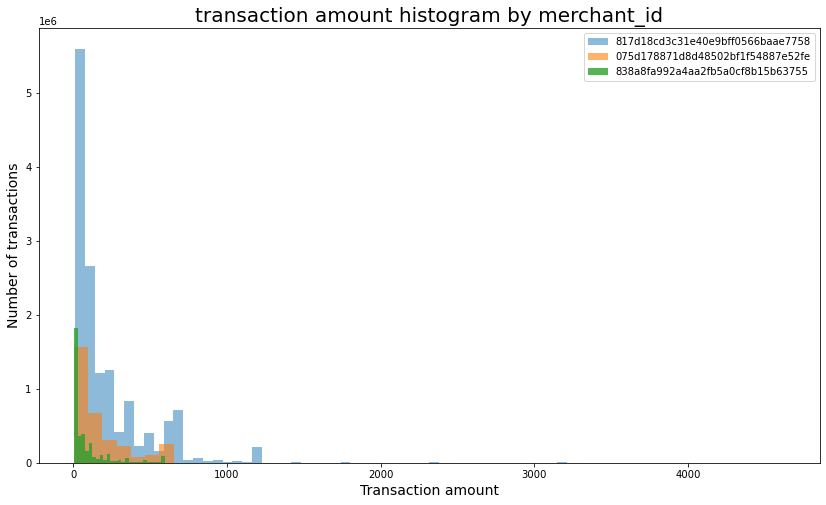

In [13]:
## plot the distribution of the transaction_amount by merchant_id
plt.figure(figsize=(14,8))

plt.hist(data[data['merchant_id']=="817d18cd3c31e40e9bff0566baae7758"]["transaction_amount"],
         alpha=0.5, # the transparency parameter
         label='817d18cd3c31e40e9bff0566baae7758',
         bins=50)

plt.hist(data[data['merchant_id']=="075d178871d8d48502bf1f54887e52fe"]["transaction_amount"],
         alpha=0.6,
         label='075d178871d8d48502bf1f54887e52fe',
         bins=50)

plt.hist(data[data['merchant_id']=="838a8fa992a4aa2fb5a0cf8b15b63755"]["transaction_amount"],
         alpha=0.8,
         label='838a8fa992a4aa2fb5a0cf8b15b63755',
         bins=50)

plt.legend(loc='upper right')
plt.title('transaction amount histogram by merchant_id',fontsize=20)
plt.xlabel("Transaction amount",fontsize=14)
plt.ylabel("Number of transactions",fontsize=14)
plt.show()

Podemos observar que el monto de la transacción esta normalizado o tal vez corresponde a montos en dólares.

Además, la gráfica anterior nos indica que es muy importante tomar en cuenta el merchant_id desde el que se realiza la transacción. Probablemente lo mejor sería hacer un modelo para cada uno de los merchant_id; sin embargo, dado que nuestra aproximación permite hacer una agrupación de los clientes con comportamientos similares, se esperaría que también se tuviera en cuenta el merchant_id al que pertenecen.


In [14]:
## evaluate the amount of transactions that can be in each subsidiary
data["subsidiary"].value_counts()

f54e0b6b32831a6307361ed959903e76    712798
8c52a2d7745e37bcee79717300f796e3    342118
d4b621a24cc03e3f92155a7e241fa1c3    331271
dff70ce33784a932ce4a7efc81a43863    240575
d4b31b123120a4eefd51ba95975f2ae4    100892
                                     ...  
0496e8a3c4c45eb1173d5098f692118d         1
4becb1ec91781b9c385ba2c518d4f723         1
81660377bd7b460e63d885194b26f486         1
2d6d38328ad1b996b39c409fd1a99be7         1
34c0681bb30a128494cd78772ff35d58         1
Name: subsidiary, Length: 16833, dtype: int64

In [15]:
## evaluate if a subsidiary can receive transactions in different merchant_id's
temp=data.groupby(["merchant_id","subsidiary"])["_id"].count().reset_index()
print("can subsidiary receive transactions from different merchan_id's?: ",sum(temp["subsidiary"].duplicated())!=0)

can subsidiary receive transactions from different merchan_id's?:  False


Existen filiales que contienen una cantidad importante de las transacciones por lo que se podrían clasificar a los clientes dentro de las filiales que son importantes (que tengan muchas transacciones), a las cuales hagan una cantidad importante de transacciones.

Además, como vimos, una filial solo puede pertenecer a un merchant_id, por lo que tal vez clasificar a los clientes según el merchant_id al que más transacciónes hagan podría ser más significativo.

### Evaluar la varianza del monto de las transacciones realizadas en el tiempo

In [16]:
## define the time delta for the analysis
timedelta_param="W"

In [17]:
## crear un dataframe que contenga el monto y varanza de todos los merchant_id's agrupados
temp_general_group=data.groupby([pd.Grouper(key="transaction_date",
                                            freq=timedelta_param)])["transaction_amount"].agg(["mean","std","count"]).reset_index()
temp_general_group["positive_std"]=temp_general_group["mean"]+temp_general_group["std"]
temp_general_group["negative_std"]=temp_general_group["mean"]-temp_general_group["std"]

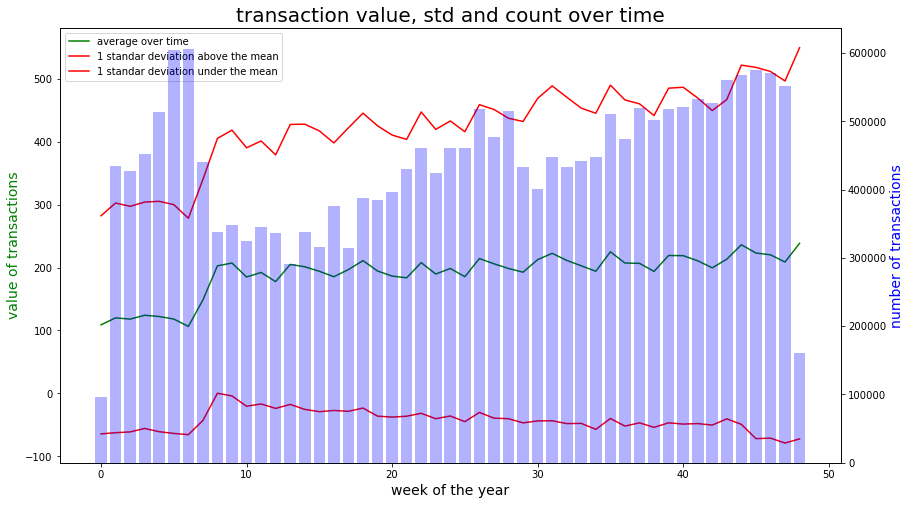

In [18]:
##plot the mean, 1 deviation from the mean and the count of transactions
fig,ax = plt.subplots(figsize=(14,8))

ax.plot(range(len(temp_general_group["transaction_date"])),
        temp_general_group["mean"],
        label="average over time",
        color="green")

ax.plot(range(len(temp_general_group["transaction_date"])),
        temp_general_group["positive_std"],
        label="1 standar deviation above the mean",
        color="red")

ax.plot(range(len(temp_general_group["transaction_date"])),
        temp_general_group["negative_std"],
        label="1 standar deviation under the mean",
        color="red")

ax.set_xlabel("week of the year", fontsize = 14)
ax.set_ylabel("value of transactions",
              color="green",
              fontsize=14)
plt.legend(loc='upper left')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.bar(range(len(temp_general_group["transaction_date"])),
        temp_general_group["count"],
        color="blue",
        alpha=0.3)
ax2.set_ylabel("number of transactions",color="blue",fontsize=14)

plt.title('transaction value, std and count over time',fontsize=20)
plt.show()

Vemos que en las primeras 5 semanas de 2021 hubo un periodo en el que el monto promedio de las transacciones era muy bajo, pero en el cual se realizaban muchas transacciones, lo cual es sospechoso.

Por otra lado vemos que n cuanto a la tendencia, incluso la varianza de los datos ha tendido a aumentar a través del tiempo, por lo que <b> es importante que cualquier análisis que se haga tenga muy en cuenta el factor del tiempo <b>

### evaluación del promedio del monto de las transacciones en el tiempo por merchant_id

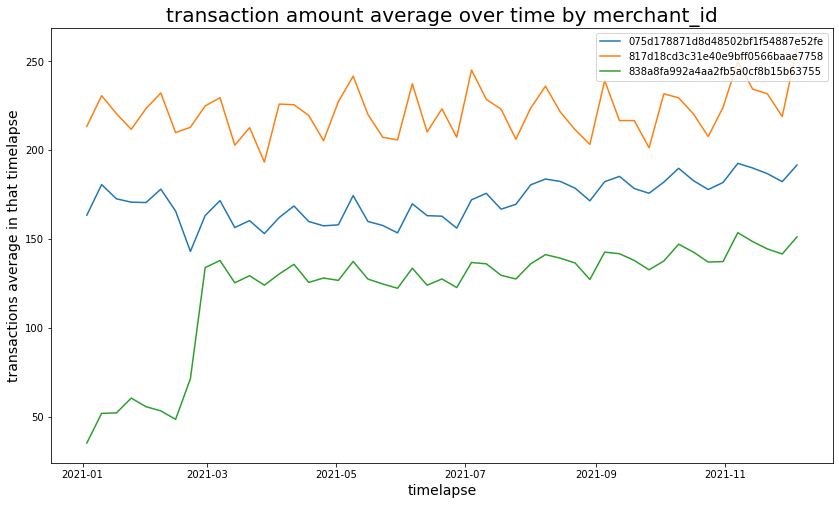

In [19]:
## create the dataframe grouped by date and merchant_id
temp_timestamp_data=data.groupby(["merchant_id",
                                  pd.Grouper(key="transaction_date",
                                            freq=timedelta_param)])["transaction_amount"].agg(["mean","count","std"]).reset_index()
## plot the behaviour of transactions over time
plt.figure(figsize=(14,8))

for i in list(data['merchant_id'].unique()):
    plt.plot(temp_timestamp_data[temp_timestamp_data["merchant_id"]==i]["transaction_date"],
             temp_timestamp_data[temp_timestamp_data["merchant_id"]==i]["mean"],
             label=i)

plt.legend(loc='upper right')
plt.title('transaction amount average over time by merchant_id',fontsize=20)
plt.xlabel("timelapse",fontsize=14)
plt.ylabel("transactions average in that timelapse",fontsize=14)
plt.show()

Acá podemos observar que el merchant_id verde tenía un comportamiento en cuanto a promedio de transacciones totalmente diferente en el principio del año; el cual explica el valle en el comportamiento general de la anterior gráfica, por lo que tal vez para agrupar a los clientes por su comportamiento usual, sería importante <b> excluir de la muestra las transacciones del merchant_id verde en los primeros meses del año <b>.
    
Además, podemos observar que <b> hay un comportamiento cíclico </b> importante cada 4 semanas y que en términos de tendencia, viene aumentando paulatinamente el monto promedio de las transacciones que se realizan en cada merchant_id.

### Base de datos con cantidad de transacciones, monto promedio y monto total por dia

In [8]:
## add a day column to the original dataframe
data["day"]=data["transaction_date"].dt.date

In [ ]:
## group by day and user_id the number of transactions and the average value as well as the total value of transactions
temp_data_user_id=data.groupby(["day","merchant_id","transaction_type","user_id"])["transaction_amount"].agg(["sum","count","mean"])

In [ ]:
## rename the columns
temp_data_user_id.columns=["total amount per day","number of transactions","average amount of transactions"]

In [22]:
## watch the schema of the dataframe we creaed
temp_data_user_id.head()

total amount per day  \
day        merchant_id                      transaction_type user_id                                                  
2021-01-01 075d178871d8d48502bf1f54887e52fe CREDITO          01ff1fcaa1fe2fc35e1310a9081022a4             59.444550   
                                                             086b3ad64d466f4db74aa9c9a6df4359            107.000190   
                                                             1d56d354a5789d924d8705b60d51d3ea             27.344493   
                                                             3e1cf6b759eca1a376b0a870dd95c871             57.066768   
                                                             51d5fc5c0608eddb1fa12c732b0de0fd            356.667301   

                                                                                               number of transactions  \
day        merchant_id                      transaction_type user_id                                                    
2021-01-01 075d178871d8d48502bf1f54887e52fe CREDITO          01ff1fcaa1fe2fc35e1310a9081022a4                       1   
                                                             086b3ad64d466f4db74aa9c9a6df4359                       1   
                                                             1d56d354a5789d924d8705b60d51d3ea                       1   
                                                             3e1cf6b759eca1a376b0a870dd95c871                       1   
                                                             51d5fc5c0608eddb1fa12c732b0de0fd                       1   

                                                                                               average amount of transactions  
day        merchant_id                      transaction_type user_id                                                           
2021-01-01 075d178871d8d48502bf1f54887e52fe CREDITO          01ff1fcaa1fe2fc35e1310a9081022a4                       59.444550  
                                                             086b3ad64d466f4db74aa9c9a6df4359                      107.000190  
                                                             1d56d354a5789d924d8705b60d51d3ea                       27.344493  
                                                             3e1cf6b759eca1a376b0a870dd95c871                       57.066768  
                                                             51d5fc5c0608eddb1fa12c732b0de0fd                      356.667301

In [23]:
temp_data_user_id[["total amount per day","number of transactions","average amount of transactions"]].describe()

,total amount per day,number of transactions,average amount of transactions
count,1.853314e+07,1.853314e+07,1.853314e+07
mean,2.220869e+02,1.160997e+00,1.875438e+02
std,3.245510e+02,1.672375e+00,2.252182e+02
min,5.944455e+00,1.000000e+00,5.944455e+00
25%,4.755564e+01,1.000000e+00,4.755564e+01
50%,1.188891e+02,1.000000e+00,1.188891e+02
75%,2.377782e+02,1.000000e+00,2.377782e+02
max,1.836171e+04,2.880000e+02,4.624786e+03


Vemos que hay usarios que han hecho hasta 288 transacciones en un mismo dia, aun cuando la gran mayoria de clientes solo hacen una transacción diaria, estos son probablmente los que son sospechosos de realizar fraccionamiento transaccional, además, el monto promedio minimo de las transacciones tambien es bajo comparado con la distribución de esta variable, por lo que puede corresponder al comportamiento transaccional de las personas que hacen fraccionamiento.

### Decidir que montos y cantidad de transacciones corresponden a un comportamiento extraño

In [ ]:
## define a function to calculate the percentile which corresponds to a extrange behaviour
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
## format some variables
temp_data_user_id=temp_data_user_id.reset_index()
temp_data_user_id["day"]=pd.to_datetime(temp_data_user_id["day"])

In [ ]:
## define a dataframe with the percentiles grouped by months
temp_graph_number_transactions=temp_data_user_id.groupby(["merchant_id","transaction_type",
                                pd.Grouper(key="day",freq="M")])["number of transactions"].\
                                agg(["count",
                                     percentile(97),
                                     percentile(98),
                                     percentile(99),
                                     percentile(99.5),
                                     percentile(99.9),
                                     percentile(99.99),
                                     percentile(99.999),
                                     percentile(100)]).reset_index()

In [2]:
## grafica de la evolución de los diferentes percentiles del numero de transacciones diario por cada user_id
merch_list=list(temp_graph_number_transactions["merchant_id"].unique())
type_list=list(temp_graph_number_transactions["transaction_type"].unique())

fig = make_subplots(rows=3, cols=2,shared_xaxes=True,
                    column_titles=type_list,
                    row_titles=[i[0:5] for i in merch_list],
                    x_title="Mes del año",
                    y_title="Número de transacciones")

col_list=['percentile_97', 'percentile_98', 'percentile_99',
          'percentile_99.5', 'percentile_99.9', 'percentile_99.99',
          'percentile_99.999', 'percentile_100']

for i in range(len(merch_list)):
    for j in range(len(type_list)):
        for x in col_list:
            fig.add_trace(go.Scatter(x=temp_graph_number_transactions[(temp_graph_number_transactions["merchant_id"]==merch_list[i]) &\
                                           (temp_graph_number_transactions["transaction_type"]==type_list[j])]["day"],
                                     y=temp_graph_number_transactions[(temp_graph_number_transactions["merchant_id"]==merch_list[i]) &\
                                           (temp_graph_number_transactions["transaction_type"]==type_list[j])][x],legendgroup=x,name=x),row=i+1, col=j+1)
               
fig.update_layout(showlegend=True,
                  title_text="Grafica de evolución de los percentiles en el tiempo por merchant_id y tipo de transacción",
                  height=1000,width=1200)

##############################################
## para ver la grafica sin correr el código ##
##############################################
fig.write_html("Graphs/figura_1.html")
fig.show()
print("ver el grafico en html")

ver el grafico en html


In [17]:
# define a dataframe with the percentiles grouped by months
temp_graph_value_transactions=temp_data_user_id.groupby(["merchant_id","transaction_type",
                                pd.Grouper(key="day",freq="M")])["average amount of transactions"].\
                                agg(["count",
                                     percentile(50),
                                     percentile(2),
                                     percentile(1),
                                     percentile(0.5),
                                     percentile(5),
                                     percentile(4),
                                     percentile(3),
                                     percentile(0)]).reset_index()

In [1]:
## graph with the percentiles for the average value of transactions over time
fig = make_subplots(rows=3, cols=2,shared_xaxes=True,
                    column_titles=type_list,
                    row_titles=[i[0:5] for i in merch_list],
                    x_title="Mes del año",
                    y_title="Monto promedio de las transacciones")

col_list=['percentile_50','percentile_2', 'percentile_1', 'percentile_0.5',
          'percentile_5', 'percentile_4', 'percentile_3',
          'percentile_0']

for i in range(len(merch_list)):
    for j in range(len(type_list)):
        for x in col_list:
            fig.add_trace(go.Scatter(x=temp_graph_value_transactions[(temp_graph_value_transactions["merchant_id"]==merch_list[i]) &\
                                           (temp_graph_value_transactions["transaction_type"]==type_list[j])]["day"],
                                     y=temp_graph_value_transactions[(temp_graph_value_transactions["merchant_id"]==merch_list[i]) &\
                                           (temp_graph_value_transactions["transaction_type"]==type_list[j])][x],legendgroup=x,name=x),row=i+1, col=j+1)
               
fig.update_layout(showlegend=True,
                  title_text="Grafica de evolución de los percentiles del monto promedio en el tiempo por merchant_id y tipo de transacción",
                  height=1000,width=1200)

##############################################
## para ver la grafica sin correr el código ##
##############################################
fig.write_html("Graphs/figura_2.html")
fig.show()
print("ver el grafico en html")

ver el grafico en html


In [ ]:
## delete variables we are no longer using
del data

En las gráficas anteriores podemos observar que, para los merchant_ids comenzados por 838a8 y 075d1, en los 3 primeros meses del año hubo comportamientos bastante atipicos en cuanto al número de transacciones y monto de las mismas, ya que se hacían muchas transacciones pero con bajos montos. Luego de estos 3 primeros meses se normalizo, además, vemos que para estos merchant_ids no tenemos información de transacciones debito para los últimos meses del año. 

Por otra parte, para el merchant_id comenzado por 817d1 se puede observar que el número de transacciones nunca alcanzo variaciones extremas y que el monto de los mismos es bastante estable por lo que, dado que los percentiles del monto promedio de mantienen estable a través del tiempo, es posible que los montos usados para este merchant_id sean fijos por rangos.

En la segunda grafica se incluyó también el percentil 50 para ver si los datos tienen variabilidad o no, pero se puede excluir de la gráfica fácilmente clicando la leyenda.

<b>HIPÓTESIS:</b>

- El comportamiento de fraccionamiento transaccional fue detectado por la entidad los primeros meses del año y se controló para los siguiente periodos, prohibiendo muchas transacciones por parte de un mismo user_id en un día.
- Existe algún tipo de componente estacionario, en el que en los primeros meses del año es cuando más se realizan estos comportamientos fraudulentos. Si este fuera el caso, se debería plantear un modelo en el que se añadiera un componente estacionario
- Dado que los merchant_id comenzados por 838a8 y 075d1 no tienen transacciones DEBITO en los últimos meses es posible que se hayan prohibido las transacciones de este tipo en ese merchant_id (también es posible que los parquets que poseemos no contengan la información completa para estos merchant_id, sin embargo, dado que no tenemos más información, se trabajara con la hipótesis planteada).

<b>CONCLUSIONES EDA:</b>
- Para realizar un modelo experto, es muy importante definir reglas para cada tipo de merchant_id y para cada tipo de transacción.
- Es una limitante tener información de un solo año ya que no se puede analizar si hay algún tipo de estacionalidad por meses, por lo que, si se tuviera más data, se debería analizar esta hipótesis para definir las reglas dependiendo de esta estacionalidad, ya que tampoco quisiéramos limitar a los clientes que usen mucho la aplicación porque se confundan con comportamientos fraudulentos.



# Punto 3

## Modelo experto enfocado a la prevención del fraude y no a la detección de usuarios fraudulentos.
Este modelo se usa para plantear límites de transacciones dependiendo del canal y el tipo de transacciones con el fin de evitar que los usuarios hagan comportamientos fraudulentos.

Este modelo funciona especialmene para los clientes que son nuevos y que no podemos perfilar de manera facil por su comportamiento transaccional. Por lo que estas reglas previenen que estos clientes que son nuevos hagan fraude.

#### Reglas transaccionales

Dado el análisis que se hizo en la etapa del EDA, se plantean las siguientes reglas transaccionales, con el fin de prevenir el fraude:

merchant_id="075d178871d8d48502bf1f54887e52fe"
- No más del percentil 99.9% del número de transacciones CREDITO por menos del percentil 3% de las transacciones realizadas en el mes anterior, por usuario en un mismo día.
- No vale la pena generar reglas para las transacciones DEBITO ya que según vimos en el EDA, es posible que están prohibidas

merchant_id="817d18cd3c31e40e9bff0566baae7758"
- No más del percentil 99.9% del número de transacciones CREDITO por menos del percentil 2% de las transacciones realizadas en el mes anterior, por usuario en un mismo día.
- No más del percentil 99.9% del número de transacciones DEBITO por menos del percentil 3% de las transacciones realizadas en el mes anterior, por usuario en un mismo día.

merchant_id="838a8fa992a4aa2fb5a0cf8b15b63755"
- No más del percentil 98% del número de transacciones CREDITO por menos del percentil 2% de las transacciones realizadas en el mes anterior, por usuario en un mismo día.
- No vale la pena generar reglas para las transacciones DEBITO ya que según vimos en el EDA, es posible que estén prohibidas.


## Modelo analítico que agrupa a clientes e identifica comportamientos atipicos

### Construcción de la base de datos

Definición de la base de datos que va a alimentar el modelo de agrupación:

<b>GENERALES</b>

- user_id.
- G_1: Variable que contiene "CREDITO" si más del 66% de sus transacciones son crédito, "DEBITO" si más del 66% de sus transacciones son débito y "BALANCEADO" si ninguno de los dos se cumple. Esta variable se calcula con las transacciones de los últimos 3 meses.
- G_2: Mediana de 3 meses del balance al final del mes del total del monto CREDITO meno el total del monto DEBITO en el mes.


<b>CRÉDITO</b>

- C_1: Mediana de 3 meses del número de transacciones a la semana.
- C_2: Mediana de 3 meses del número total de transacciones al mes.
- C_3: Mediana de 3 meses del monto total de transacciones al mes.
- C_4: Mediana de 3 meses del monto promedio de las transacciones en el día.
- C_5: Mediana de 3 meses del monto total de transacciones semanales.
- C_6: Merchant_id al que más transacciones Crédito realiza (Es una variable categórica por lo que es probable que se necesite un k-prototypes).

<b>DEBITO</b>

- D_1: Mediana de 3 meses del número de transacciones a la semana.
- D_2: Mediana de 3 meses del número total de transacciones al mes.
- D_3: Mediana de 3 meses del monto total de transacciones al mes.
- D_4: Mediana de 3 meses del monto promedio de las transacciones en el día.
- D_5: Mediana de 3 meses del monto total de transacciones semanales.
- D_6: Merchant_id al que más transacciones Debito realiza (Es una variable categórica por lo que es probable que se necesite un k-prototypes).

<b> TRANSACCIONALES </b>
- T_1: Promedio de días entre transacciones.

<b>VARIABLES PERSONALES</b>

- NOTA: Seria de gran ayuda si tuviéramos más variables cualitativas del cliente como la edad, actividad económica y demás, pero, como no tenemos más variables se trabajara solo con variables transaccionales.


### Dividir la base de datos para quedarnos con la parte que vamos a usar para estimar el modelo (3 meses )

In [ ]:
## this division cant be made on a random way because the date of the transactions is very important
train_data=temp_data_user_id[temp_data_user_id["day"]<"2021-07-01"]
test_data=temp_data_user_id[temp_data_user_id["day"]>="2021-07-01"]

### Tratamiento de datos atipicos y flujo de datos

En cuanto al flujo de los datos, se propone cargar tan solo los fragmentos parquet que contengan la información transaccional de los ultimos 3 meses del cliente. Sin embargo, en caso de que las particiones en los parquet no sean tan exactas, dentro del script se hace la division de los datos.

In [23]:
## first, we treat the data that feed our entire model
train_data.head()

,day,merchant_id,transaction_type,user_id,total amount per day,number of transactions,average amount of transactions
0,2021-01-01,075d178871d8d48502bf1f54887e52fe,CREDITO,01ff1fcaa1fe2fc35e1310a9081022a4,59.444550,1,59.444550
1,2021-01-01,075d178871d8d48502bf1f54887e52fe,CREDITO,086b3ad64d466f4db74aa9c9a6df4359,107.000190,1,107.000190
2,2021-01-01,075d178871d8d48502bf1f54887e52fe,CREDITO,1d56d354a5789d924d8705b60d51d3ea,27.344493,1,27.344493
3,2021-01-01,075d178871d8d48502bf1f54887e52fe,CREDITO,3e1cf6b759eca1a376b0a870dd95c871,57.066768,1,57.066768
4,2021-01-01,075d178871d8d48502bf1f54887e52fe,CREDITO,51d5fc5c0608eddb1fa12c732b0de0fd,356.667301,1,356.667301


In [ ]:
## filter the data for just the last 3 months which is the data that we need to estimate the model.
first_date=train_data["day"].max()-timedelta(days=90)
train_data=train_data[train_data["day"]>=first_date]

In [ ]:
## replace the merchant_id for a discrete number
train_data["merchant_id"]=train_data["merchant_id"].replace(list(train_data["merchant_id"].unique()),[1,2,3])

In [ ]:
## create a copy to save the merchant_id
train_data_1=train_data.copy(deep=True)

## create another dataframe that contains merchant_id and just group data by credit and debit.
train_data=train_data.groupby(["day","transaction_type","user_id"])[["total amount per day","number of transactions"]].sum().reset_index()
train_data["average amount of transactions"]=train_data["total amount per day"]/train_data["number of transactions"]

In [ ]:
## calculate the tresholds to detect atypical values in our data
## here we use the classic aproximation of finding atypical values with distance in standar_deviations from the mean

## it is important to treat different credit and debit transactions because in the EDA we observed that 
## those 2 types of transactions hava a different behaviour

## for the number of transactions
no_tran_tresh_cre=max(train_data[train_data["transaction_type"]=="CREDITO"]["number of transactions"].mean()+2*train_data[train_data["transaction_type"]=="CREDITO"]["number of transactions"].std(),4)
no_tran_tresh_deb=max(train_data[train_data["transaction_type"]=="DEBITO"]["number of transactions"].mean()+2*train_data[train_data["transaction_type"]=="DEBITO"]["number of transactions"].std(),4)

## for the total amount per day
total_value_day_tresh_cre=train_data[train_data["transaction_type"]=="CREDITO"]["total amount per day"].mean()+2*train_data[train_data["transaction_type"]=="CREDITO"]["total amount per day"].std()
total_value_day_tresh_deb=train_data[train_data["transaction_type"]=="DEBITO"]["total amount per day"].mean()+2*train_data[train_data["transaction_type"]=="DEBITO"]["total amount per day"].std()

## for the average of transaction value per day
avg_value_day_tresh_cre=train_data[train_data["transaction_type"]=="CREDITO"]["average amount of transactions"].mean()+2*train_data[train_data["transaction_type"]=="CREDITO"]["average amount of transactions"].std()
avg_value_day_tresh_deb=train_data[train_data["transaction_type"]=="DEBITO"]["average amount of transactions"].mean()+2*train_data[train_data["transaction_type"]=="DEBITO"]["average amount of transactions"].std()

In [ ]:
## replace atyplical values for the treshold
train_data.loc[(train_data["transaction_type"]=="CREDITO")&(train_data["number of transactions"]>=no_tran_tresh_cre),"number of transactions"]=no_tran_tresh_cre
train_data.loc[(train_data["transaction_type"]=="DEBITO")&(train_data["number of transactions"]>=no_tran_tresh_deb),"number of transactions"]=no_tran_tresh_deb
train_data.loc[(train_data["transaction_type"]=="CREDITO")&(train_data["total amount per day"]>=total_value_day_tresh_cre),"total amount per day"]=total_value_day_tresh_cre
train_data.loc[(train_data["transaction_type"]=="DEBITO")&(train_data["total amount per day"]>=total_value_day_tresh_deb),"total amount per day"]=total_value_day_tresh_deb
train_data.loc[(train_data["transaction_type"]=="CREDITO")&(train_data["average amount of transactions"]>=avg_value_day_tresh_cre),"average amount of transactions"]=avg_value_day_tresh_cre
train_data.loc[(train_data["transaction_type"]=="DEBITO")&(train_data["average amount of transactions"]>=avg_value_day_tresh_deb),"average amount of transactions"]=avg_value_day_tresh_deb

In [3]:
fig = make_subplots(rows=3, cols=1,shared_xaxes=False,
                    subplot_titles=["Histograma del monto total por dia",
                                  "Histograma del numero de transacciones por dia",
                                  "histograma del monto promedio por dia"],
                    x_title="Cantidad de clientes")

col_list=['total amount per day','number of transactions', 'average amount of transactions']

for i in range(len(col_list)):
    fig.add_trace(go.Histogram(x=train_data[col_list[i]],legendgroup=col_list[i],name=col_list[i],
                              nbinsx=50),row=i+1, col=1)

fig.update_layout(showlegend=False,
                  title_text="Histogramas de las variables luego del tratamiento",
                  height=1000,width=800)

##############################################
## para ver la grafica sin correr el código ##
##############################################
fig.write_html("Graphs/figure_3.html")
fig.show()
print("ver el grafico en html")

ver el grafico en html


### construcción de la base de datos usada en el modelo

In [ ]:
## begin by the average value of the transactions
final_data=pd.DataFrame(train_data[train_data["transaction_type"]=="CREDITO"].groupby("user_id")['average amount of transactions'].median())

## add the debit part
final_data=pd.concat([final_data,train_data[train_data["transaction_type"]=="DEBITO"].groupby("user_id")['average amount of transactions'].median()],axis=1)
final_data.columns=["C4","D4"]

In [ ]:
## dataframe to estimate c_1,c_5,D_1,D_5
temp_w_data=train_data.groupby(["transaction_type","user_id",pd.Grouper(key="day",freq="W")])[['total amount per day','number of transactions']].sum().reset_index()
final_data["C_1"]=temp_w_data[temp_w_data["transaction_type"]=="CREDITO"].groupby("user_id")["number of transactions"].median()
final_data["C_5"]=temp_w_data[temp_w_data["transaction_type"]=="CREDITO"].groupby("user_id")['total amount per day'].median()
final_data["D_1"]=temp_w_data[temp_w_data["transaction_type"]=="DEBITO"].groupby("user_id")["number of transactions"].median()
final_data["D_5"]=temp_w_data[temp_w_data["transaction_type"]=="DEBITO"].groupby("user_id")['total amount per day'].median()
del temp_w_data

In [ ]:
## dataframe to estimate c_2,c_3,D_2,D_3
temp_w_data=train_data.groupby(["transaction_type","user_id",pd.Grouper(key="day",freq="M")])[['total amount per day','number of transactions']].sum().reset_index()
final_data["C_2"]=temp_w_data[temp_w_data["transaction_type"]=="CREDITO"].groupby("user_id")["number of transactions"].median()
final_data["C_3"]=temp_w_data[temp_w_data["transaction_type"]=="CREDITO"].groupby("user_id")['total amount per day'].median()
final_data["D_2"]=temp_w_data[temp_w_data["transaction_type"]=="DEBITO"].groupby("user_id")["number of transactions"].median()
final_data["D_3"]=temp_w_data[temp_w_data["transaction_type"]=="DEBITO"].groupby("user_id")['total amount per day'].median()
del temp_w_data

In [ ]:
## the average of days between transactions T_1
train_data.sort_values("day",inplace=True)
temp_freq_data=train_data.groupby(["user_id","day"])["number of transactions"].sum().reset_index()
temp_freq_data["diff"]=list(temp_freq_data.groupby("user_id")["day"].diff())
temp_freq_data=temp_freq_data.groupby("user_id")["diff"].mean()
final_data["T_1"]=temp_freq_data
del temp_freq_data

In [ ]:
## to estimate G_2
train_data["symbol_var"]=[j*-1 if i=="DEBITO" else j for i,j in zip(train_data["transaction_type"],train_data["total amount per day"])]
temp_w_data=train_data.groupby(["user_id",pd.Grouper(key="day",freq="M")])['total amount per day'].sum().reset_index()
final_data["G_2"]=temp_w_data.groupby("user_id")["total amount per day"].median()
del temp_w_data

In [ ]:
## to estimate G_1
temp_g1=pd.DataFrame(train_data[train_data["transaction_type"]=="CREDITO"].groupby("user_id")["number of transactions"].sum())
temp_g1=pd.concat([temp_g1,pd.DataFrame(train_data[train_data["transaction_type"]=="DEBITO"].groupby("user_id")["number of transactions"].sum())],axis=1)
temp_g1.columns=["CREDITO","DEBITO"]
temp_g1.fillna(0,inplace=True)
temp_g1["RATIO"]=[i/(i+j) for i,j in zip(temp_g1["CREDITO"],temp_g1["DEBITO"])]
temp_g1["G_1"]=["CREDITO" if i>0.66 else "BALANCEADO" for i in temp_g1["RATIO"]]
temp_g1["G_1"]=["DEBITO" if i<0.34 else j for i,j in zip(temp_g1["RATIO"],temp_g1["G_1"])]
final_data["G_1"]=temp_g1["G_1"]
del temp_g1

In [ ]:
## script to estimate C_6
temp_c6=train_data_1[train_data_1["transaction_type"]=="CREDITO"].groupby(["user_id","merchant_id"])["number of transactions"].sum().reset_index()
temp_c6=temp_c6.sort_values(["user_id","number of transactions"])
temp_c6=temp_c6.groupby("user_id")["merchant_id"].last()
final_data["C_6"]=temp_c6
del temp_c6

In [ ]:
## script to estimate D_6
temp_d6=train_data_1[train_data_1["transaction_type"]=="DEBITO"].groupby(["user_id","merchant_id"])["number of transactions"].sum().reset_index()
temp_d6=temp_d6.sort_values(["user_id","number of transactions"])
temp_d6=temp_d6.groupby("user_id")["merchant_id"].last()
final_data["D_6"]=temp_d6
del temp_d6,train_data_1

In [ ]:
## fill the NA's with 0 on the final dataframe and format categoical variables and timedelta
final_data["T_1"]=[0 if j else i.days for i,j in zip(final_data["T_1"],final_data["T_1"].isna())]
final_data.fillna(0,inplace=True)
final_data["C_6"]=[str(i) for i in final_data["C_6"]]
final_data["D_6"]=[str(i) for i in final_data["D_6"]]
final_data.head()

In [ ]:
del temp_data_user_id,train_data

### Construcción del modelo de clustering con K-prototypes y Affinity propagation

Para la construcción del modelo, dado que no es un modelo de aprendizaje supervisado, no es necesario dividir la muestra en entrenamiento y testeo. Además, lo que se busca en este modelo es que haya la mayor homogeneidad posible en los grupos, pero que haya la mayor heterogeneidad entre diferentes grupos.

Es por esto que los resultados del modelo se van a evaluar con el coeficiente de silueta para las variables numericas, el cual es un gran indicador de los criterios mencionados anteriormente.

<b>Vuelvo a poner el diccionario de la base de datos:</b>

<b>GENERALES</b>

- user_id.
- G_1: Variable que contiene "CREDITO" si más del 66% de sus transacciones son crédito, "DEBITO" si más del 66% de sus transacciones son débito y "BALANCEADO" si ninguno de los dos se cumple. Esta variable se calcula con las transacciones de los últimos 3 meses.
- G_2: Mediana de 3 meses del balance al final del mes del total del monto CREDITO meno el total del monto DEBITO en el mes.


<b>CRÉDITO</b>

- C_1: Mediana de 3 meses del número de transacciones a la semana.
- C_2: Mediana de 3 meses del número total de transacciones al mes.
- C_3: Mediana de 3 meses del monto total de transacciones al mes.
- C_4: Mediana de 3 meses del monto promedio de las transacciones en el día.
- C_5: Mediana de 3 meses del monto total de transacciones semanales.
- C_6: Merchant_id al que más transacciones Crédito realiza (Es una variable categórica por lo que es probable que se necesite un k-prototypes).

<b>DEBITO</b>

- D_1: Mediana de 3 meses del número de transacciones a la semana.
- D_2: Mediana de 3 meses del número total de transacciones al mes.
- D_3: Mediana de 3 meses del monto total de transacciones al mes.
- D_4: Mediana de 3 meses del monto promedio de las transacciones en el día.
- D_5: Mediana de 3 meses del monto total de transacciones semanales.
- D_6: Merchant_id al que más transacciones Debito realiza (Es una variable categórica por lo que es probable que se necesite un k-prototypes).

<b> TRANSACCIONALES </b>
- T_1: Promedio de días entre transacciones.

In [44]:
## description of the dataframe
final_data.describe()

,C4,D4,C_1,C_5,D_1,D_5,C_2,C_3,D_2,D_3,T_1,G_2
count,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06,1.376046e+06
mean,4.707570e+01,1.341089e+02,3.400857e-01,5.346980e+01,9.567347e-01,1.685634e+02,4.074758e-01,6.236445e+01,1.575450e+00,2.794363e+02,9.706322e+00,3.261768e+02
std,1.055397e+02,1.515446e+02,5.422106e-01,1.271085e+02,6.249073e-01,2.090074e+02,8.320155e-01,1.619182e+02,1.710958e+00,4.215258e+02,1.389084e+01,4.283715e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.944455e+00
25%,0.000000e+00,2.377782e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.377782e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.972228e+01,0.000000e+00,7.133346e+01
50%,0.000000e+00,8.322237e+01,0.000000e+00,0.000000e+00,1.000000e+00,9.867795e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.307780e+02,4.000000e+00,1.842781e+02
75%,3.566673e+01,1.902226e+02,1.000000e+00,3.566673e+01,1.000000e+00,2.377782e+02,1.000000e+00,3.566673e+01,2.000000e+00,3.566673e+02,1.400000e+01,4.161119e+02
max,4.800640e+02,6.152989e+02,1.600000e+01,3.061066e+03,1.900000e+01,5.231691e+03,5.500000e+01,1.085198e+04,8.200000e+01,1.964451e+04,9.000000e+01,2.374977e+04


In [ ]:
## leave the user_id as a variable of the DataFrame
final_data=final_data.reset_index()

## save the data in case the kernel breaks.
# # final_data.to_csv("Data_1/datos_modelo_df.csv")
# model_df=pd.read_csv("Data/datos_modelo_df.csv",index_col=0)

In [78]:
#EDA using pandas-profiling
# profile = ProfileReport(df=final_data,
#                         minimal=False)

# # #Saving results to a HTML file
# profile.to_file("EDA_final_data.html")

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<b>Note</b>: En caso de que se quiera correr el código, probablemente deban seguir las siguientes instrucciones:

https://stackoverflow.com/questions/68704002/importerror-cannot-import-name-abcindexclass-from-pandas-core-dtypes-generic

Sin embargo, abriendo el archivo <b>"EDA_final_data.html"</b> que esta en la carpeta de la prueba, se puede ver el reporte.

Por otra parte, dado el EDA que se realiza sobre esta base, se puede observar que <b>hay variables que necesitan tratamiento de datos atípicos</b> para que no afecten de manera muy drástica la estandarización que se va a realizar posteriormente. Esto se concluye ya que variables como "C_5" tienen distribuciones con colas muy alargadas y valores extremos muy desfasados de los valores comunes.

Ademas, vemos que un 57,5% de los datos de la base estan duplicados. En este caso se decide dejar los duplicados ya que da cierta información adicional para los centroides de que el cluster puede estar mas cercano a esos valores duplicados que a otro tipo de comportamiento de clientes que este mas disperso.

#### Tratamiento de outliers de la base de datos final
Se define una función que permite realizar el tratamiento de outliers por 2 metodologias diferentes. vale la pena mencionar que las variables categoricas no se tratan en este caso ya que, a pesar de que algunas de ellas estan muy concentradas tal como se observa en el EDA, es posible que estas concentraciones decidan de cierta manera manera agrupaciones entre clientes con comportamientos similares.

In [ ]:
## function to treat outliers no matter the distribution of the data
def outliers_treatment(dataset,variables='todas',## we can pass todas so it takes all the data frame or the list of variables we want to use
                       variables_exclude=[],## we can exclude some variables from the dataset
                       perc_step=2.5, ## how many percent will be reach bin when dividing the dataset. 
                       correction_type='replace',## it can be replace or exlude depending on the method you want to use
                       exclude_negatives=True, ## if you want to replace the negatives with missing values
                       methodology='percentile', ## methodology could be "percentile" or "std"
                       std_integer=2): ## if methodology == "std" decide how much std would you accept among the "normal" data
    data=dataset.copy(deep=True)
    if exclude_negatives:
        data[(data<0)]=None
    if variables=='todas':
        columnas_convertir=data.columns.tolist()
        [columnas_convertir.remove(i) for i in variables_exclude]
    else:
        columnas_convertir=variables
    if correction_type=='replace':
        for variable in columnas_convertir:
            if methodology=='percentile':
                ## sacamos los percentiles de la distribución, asi como el minimo y el maximo de la serie
                tabla_percentiles=np.percentile(data[variable].dropna(),np.arange(0,101,perc_step),interpolation='midpoint').tolist()
                ## miramos en que percentiles se presenta el rango mas alto de la distribiución
                tabla_diferencias=np.diff(tabla_percentiles)

                ## Sacamos los dos percentiles que pertenecen a los rangos mas amplios
                argsort_differences=tabla_diferencias.argsort()
                list_int_index=argsort_differences[-2:].tolist()

                ## miramos los rangos de percentiles que mas separados estan en la distribución

                array_percentiles=[]
                for index in list_int_index:
                    array_percentiles.append(tabla_percentiles[index:index+2])
                if (abs(list_int_index[0]-list_int_index[1])==1):
                    ## primer caso en el que los dos estan pegados en la punta derecha
                    if bool(np.isin(np.max(argsort_differences),list_int_index)):
                        data.loc[(data[variable]>=np.min(array_percentiles)),variable]=np.min(array_percentiles)
                    ## Segundo caso en el que los dos estan pegados en la cola izquierda
                    elif bool(np.isin(np.min(argsort_differences),list_int_index)):
                        data.loc[(data[variable]>=np.max(array_percentiles)),variable]=np.max(array_percentiles)
                    ## tercer caso en el que estan pegados en el medio
                    else:
                        ## en este caso si importa el orden para saber si asignarle el maximo o el minimo del percentil
                        if list_int_index[0]>list_int_index[1]:
                            data.loc[(data[variable].between(array_percentiles[0][0],array_percentiles[0][1])),variable]=np.max(array_percentiles[0])
                            data.loc[(data[variable].between(array_percentiles[1][0],array_percentiles[1][1])),variable]=np.min(array_percentiles[1])
                        elif list_int_index[1]>list_int_index[0]:
                            data.loc[(data[variable].between(array_percentiles[0][0],array_percentiles[0][1])),variable]=np.min(array_percentiles[0])
                            data.loc[(data[variable].between(array_percentiles[1][0],array_percentiles[1][1])),variable]=np.max(array_percentiles[1])
                else:
                    for array in array_percentiles:
                        if array[0]==np.min(tabla_percentiles):
                            data.loc[(data[variable].between(array[0],array[1])),variable]=array[1]
                        elif array[1]==np.max(tabla_percentiles):
                            data.loc[(data[variable].between(array[0],array[1])),variable]=array[0]
                        else:
                            medium=(array[1]+array[0])/2
                            data.loc[(data[variable].between(array[0],medium)),variable]=array[0]
                            data.loc[(data[variable].between(medium,array[1])),variable]=array[1]
            elif methodology=='std':
                ## Media y desviacion standar de la serie
                desviacion=data[variable].std()
                media=data[variable].mean()

                # Reemplazamos la cola izquierda por la media -2 vecesa la desviación
                data.loc[(data[variable]<(media-std_integer*desviacion)),variable]=media-std_integer*desviacion

                # Hacemos lo mismo para la cola derecha
                data.loc[(data[variable]>(media+std_integer*desviacion)),variable]=media+std_integer*desviacion

    elif correction_type=='exclude':
        for variable in data.columns:
            if methodology=='percentile':
                print(variable)
                ## sacamos los percentiles de la distribución, asi como el minimo y el maximo de la serie
                tabla_percentiles=np.percentile(data[variable].dropna(),np.arange(0,101,perc_step),interpolation='midpoint').tolist()
                ## miramos en que percentiles se presenta el rango mas alto de la distribiución
                tabla_diferencias=np.diff(tabla_percentiles)

                ## Sacamos los dos percentiles que pertenecen a los rangos mas amplios
                argsort_differences=tabla_diferencias.argsort()
                list_int_index=argsort_differences[-2:].tolist()

                ## miramos los rangos de percentiles que mas separados estan en la distribución

                array_percentiles=[]
                for index in list_int_index:
                    array_percentiles.append(tabla_percentiles[index:index+2])
                data.drop(data[data[variable].between(array_percentiles[0][0],array_percentiles[0][1])].index)
                data.drop(data[data[variable].between(array_percentiles[0][0],array_percentiles[0][1])].index)
            elif methodology=='std':
                ## Media y desviacion standar de la serie
                desviacion=data[variable].std()
                media=data[variable].mean()

                # Reemplazamos la cola izquierda por la media -2 vecesa la desviación
                data.drop(data.loc[(data[variable]<(media-std_integer*desviacion)),variable].index)

                # Hacemos lo mismo para la cola derecha
                data.drop(data.loc[(data[variable]>(media+std_integer*desviacion)),variable].index)

    return data

In [ ]:
## outliers treatment for any data distribution form
final_data_1=outliers_treatment(final_data,
                  variables="todas",
                  variables_exclude=["user_id","G_1","C_6","D_6"],
                  perc_step=1,
                  correction_type="replace",
                  exclude_negatives=False,
                  methodology="percentile")

# delete dataframes used before to save memory
del final_data

In [80]:
# #EDA for the treated data using pandas-profiling
# profile = ProfileReport(df=final_data_1,
#                         minimal=False)

# # #Saving results to a HTML file
# profile.to_file("EDA_final_data_treated.html")

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Luego de hacer el tratamiento, vemos que las distribuciones de los datos mejoraron y no hay outliers tan extremos como se presentaban antes del tratamiento. 

En cuanto a las variables del número de transacciones, dado que muy pocos clientes hacen más de 3 transacciones al mes, quedaron como si fueran una categórica ordinal, sin embargo, esto no es malo ya que queremos encontrar grupos de personas con comportamientos similares pero aún no es necesario detectar cuales son los outliers.

#### Escalamiento de las variables numericas.
Para cualquier modelo que se base en distancias es necesario hacer un escalado de los datos, para que las variables sean comparadas entre si. En este caso se decidira hacer un tratamiento MinMax de manera experta; sin embargo, con un poco mas de tiempo se deberian testear diferentes tipos de escalado para ver cual genera el mejor resultado en el agrupamiento.

In [ ]:
## divide dataframe in numerical and categorical variables
cat_variables=final_data_1[['G_1', 'C_6', 'D_6']]
num_variables=final_data_1[['C4', 'D4', 'C_1', 'C_5', 'D_1', 'D_5', 'C_2', 'C_3', 'D_2','D_3', 'T_1', 'G_2']]
cols_num=num_variables.columns
del final_data_1

In [ ]:
## scale numerical values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(num_variables.values)
num_variables=pd.DataFrame(data=scaler.transform(num_variables.values),columns=cols_num)

In [50]:
## base de datos final usada para el modelo con el escalamiento de los datos
model_df=pd.concat([num_variables,cat_variables],axis=1)

#### Desarrollo y evaluación del modelo de Affinity propagation
Dado que este modelo no recibe como input la cantidad de clústeres iniciales, es una buena primera aproximación para estimar el número de clústeres tentativos que podríamos tener. Sin embargo, el problema de este modelo es que es muy intensivo en el uso de memoria, por lo que hay que entrenarlo con una porción mucho más pequeña de la base de datos. Además, este modelo no recibe variables categóricas, por lo que existe la opción de discretizar las categóricas, pero como este es un modelo intermedio al final, solo se van a usar las variables numéricas para este caso.

In [114]:
random_numerical_data,leftover = train_test_split(num_variables.drop_duplicates(), train_size=0.01, random_state=42,shuffle=True)

In [115]:
# define the model
model = AffinityPropagation(damping=0.7)

# train the model
model.fit(random_numerical_data.values)

# assign each data point to a cluster
result = model.predict(random_numerical_data)

# get all of the unique clusters
clusters = unique(result)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but AffinityPropagation was fitted without feature names



In [132]:
## analize the number of clusters that the model retrieves
len(clusters)

155

Dado que el modelo arroja tantos clústeres, no se considera como un modelo potencial a usar en este caso.

<b>Nota :</b> Vale la pena mencionar que el modelo no se probó con los hiperparametros tuneados, sin embargo, dado que el modelo es tan intensivo en términos computacionales se descarta y se prueba el uso de K-prototypes.


#### desarrollo y evaluación del modelo de K-prototypes
Este modelo nos es muy util ya que nos permite incorporar variables categoricas dentro del análisis a comparación del Kmeans y, además, podemos tunear el numero de clusteres evaluando su resultado con el costo.

In [51]:
del num_variables,cat_variables

In [35]:
## train the model with a portion of the non duplicated data for computation efficiency

## I know the sample may be not representative of the total dataframe but giving the fact that kprototypes is inefficient
## to run in large dataset, I just wanted to ilustrate the process to get a good model because I dont have a good machine.
random_numerical_data,leftover = train_test_split(model_df.drop_duplicates(), train_size=0.003, random_state=43,shuffle=True)

In [36]:
## shape of the dataframe to estimate out model
random_numerical_data.shape

(1799, 15)

In [37]:
## columns that the algorithm will take as categorical values
catColumnsPos=list(where(random_numerical_data.columns.isin(["G_1","C_6","D_6"]))[0])

In [44]:
## elbow method to get the optimal number of clusters for the k-prototypes algoritm
cost = []
for cluster in range(5, 15):
    try:
        kprototype = KPrototypes(n_jobs = -1,max_iter=50,n_init=5, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(random_numerical_data.values, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11
Cluster initiation: 12
Cluster initiation: 13
Cluster initiation: 14


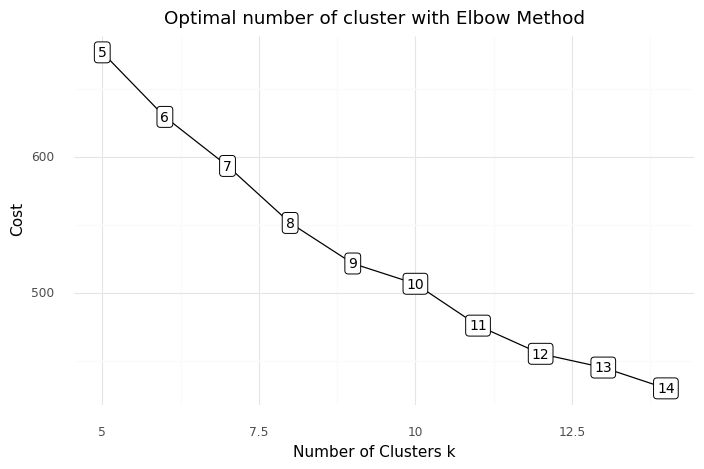

<ggplot: (127130385523)>

In [45]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(5, 15), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 0) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

Dada la grafica anterior, se selecciona 10 como el numero de clusters optimo.

<b>Nota: </b> Es importante menionar que dado que no s e entreno con una muestra significativa, probablmente el resultado no sea el correcto. Sin embargo, el pipeline si es el correcto y tal vez, con un poder de procesamiento mayor, se podria realizar un modelo mucho mas preciso. 

In [40]:
## tune the optimal value of gamma
cost = []
for gamma in [0.2,0.5,0.9]:
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = 10, init = 'Huang', random_state = 0,gamma=gamma)
        kprototype.fit_predict(random_numerical_data.values, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(gamma))
    except:
        break

Cluster initiation: 0.2
Cluster initiation: 0.5
Cluster initiation: 0.9


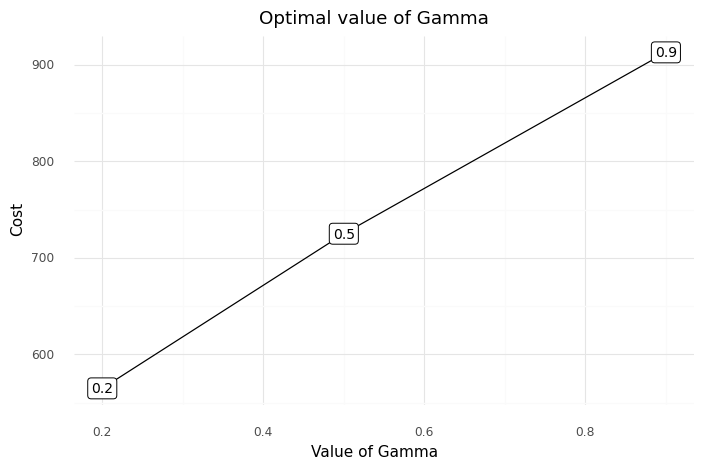

<ggplot: (127129085922)>

In [43]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Gamma':[0.2,0.5,0.9], 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Gamma',
                  y = 'Cost'))+
    geom_point(aes(x = 'Gamma',
                   y = 'Cost'))+
    geom_label(aes(x = 'Gamma',
                   y = 'Cost',
                   label = 'Gamma'),
               size = 10,
               nudge_y = 0) +
    labs(title = 'Optimal value of Gamma')+
    xlab('Value of Gamma')+
    ylab('Cost')+
    theme_minimal()
)

De esta grafica podemos interpretar que el mejor valor de gamma es el mas pequeño, lo cual significa que las variables categoricas no tienen importancia y, de hecho, significa que seria mejor evaluar la posibilidad de hacer un Kmeans en lugar de un Kprototypes. Sin embargo, por tiempo no se realizara el modelo de Kmeans.

In [46]:
## develop the selected model with the tuned hyperparameters
model=KPrototypes(n_jobs = -1, n_clusters = 10, init = 'Huang', random_state = 0,gamma=0.2)
model.fit_predict(random_numerical_data.values, categorical = catColumnsPos)

random_numerical_data["cluster"]=model.labels_
random_numerical_data["unos"]=1

In [60]:
#random_numerical_data.to_csv("Data_1/clusters_data.csv")

In [49]:
## vemos el comportamiento promedio de los clientes asociados a cada cluster
random_numerical_data.groupby('cluster').agg(
    {
        'G_1':lambda x: x.value_counts().index[0],
        'C_6': lambda x: x.value_counts().index[0],
        'D_6': lambda x: x.value_counts().index[0],
        'C4': 'mean',
        'D4': 'mean',
        'C_1': 'mean',
        'D_1': 'mean',
        'D_2': 'mean',
        'C_2': 'mean',
        'D_3': 'mean',
        'C_3': 'mean',
        'C_5': 'mean',
        'C_5': 'mean' 
    }
).reset_index()

,cluster,G_1,C_6,D_6,C4,D4,C_1,D_1,D_2,C_2,D_3,C_3,C_5
0,0,BALANCEADO,1.0,1.0,0.196426,0.197108,0.503145,0.012579,0.151730,0.561321,0.098816,0.177211,0.161045
1,1,DEBITO,1.0,2.0,0.158572,0.227238,0.527778,0.109568,0.332948,0.567901,0.246192,0.142456,0.133401
2,2,DEBITO,1.0,2.0,0.789409,0.254241,0.596330,0.057339,0.185780,0.731651,0.204908,0.825124,0.748871
3,3,DEBITO,0.0,3.0,0.000000,0.154320,0.000000,0.085784,0.262868,0.000000,0.144431,0.000000,0.000000
4,4,DEBITO,0.0,2.0,0.003040,0.650574,0.011161,0.177455,0.343750,0.011161,0.662526,0.002367,0.002388
5,5,DEBITO,0.0,2.0,0.002150,0.197414,0.003472,0.539931,0.730469,0.003472,0.581738,0.001674,0.001689
6,6,CREDITO,1.0,0.0,0.200746,0.020044,0.550000,0.000000,0.022266,0.776563,0.009589,0.282629,0.183172
7,7,DEBITO,0.0,2.0,0.000000,0.185513,0.000000,0.076844,0.321977,0.000000,0.226350,0.000000,0.000000
8,8,DEBITO,0.0,1.0,0.000000,0.208824,0.000000,0.051250,0.201250,0.000000,0.143900,0.000000,0.000000
9,9,DEBITO,1.0,2.0,0.537663,0.597310,0.549020,0.500000,0.602941,0.696078,0.810899,0.592690,0.491732


En la anterior tabla observamos las características promedio de cada uno de los grupos que se generaron con el modelo. por lo tanto, vemos que hay grupos que tienden a hacer más transacciones Debito, que tienden a hacer más transacciones en unos merchant_id que en otros. También algunos que solo hacen transacciones crédito y nunca han hecho débito y demás.

Luego de que tenemos a las personas agrupadas por tipo de comportamiento, generamos reglas para cada uno de los grupos con el fin de identificar cuáles de esos clientes se han salido del comportamiento usual de dicho grupo.


### Construción de las reglas transaccinales para cada uno de los grupos

Dado que la idea de este modelo es detectar fraccionamiento transaccional se van a generar reglas, tal como en la aproximación experta, para el numero de transacciones maximas que pueden realizar por dia y el monto minimo de las mismas.

In [51]:
## define a function to calculate the percentile which corresponds to a extrange behaviour
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
## I have saved the run until here in case the kernel breaks
#random_numerical_data=pd.read_csv("Data_1/clusters_data.csv",index_col=0)

In [ ]:
## transformar la data a sus valores originales sin el scaler
clusters_labels=random_numerical_data["cluster"]
numeric_values=scaler.inverse_transform(random_numerical_data[list(cols_num)].values)
df_original=pd.DataFrame(numeric_values,columns=cols_num)
df_original["cluster"]=clusters_labels

In [ ]:
## Creamos las reglas para el numero y monto minimo de transacciones en el dia
## Para esto usamos las transacciones que esten Alpha rangos intercuantilico mas alla de su media.

Alpha=1

df_original.groupby('cluster').agg(
    {
        'C_1': lambda x: x.mean()+Alpha*(np.percentile(x,75)-np.percentile(x,25)),
        'D_1': lambda x: x.mean()+Alpha*(np.percentile(x,75)-np.percentile(x,25)),
        'D4': lambda x: x.mean()-Alpha*(np.percentile(x,75)-np.percentile(x,25)),
        'C4': lambda x: x.mean()-Alpha*(np.percentile(x,75)-np.percentile(x,25)),
    }
).reset_index()

### resultado del modelo.
la tabla anterior nos muestra una serie de reglas para cada clúster, donde por ejemplo, los clientes del clúster 0 no podrán hacer más de 2 transacciones crédito al día por menos de 5.94 y así para cada clúster, tanto para operaciones DEBITO como CREDITO.

## Punto 3.2

La idea de este modelo es que se estime el clúster al cual pertenece la persona de manera mensual y que se revise diariamente si está incumpliendo las reglas transaccionales que se generaron en el mes inmediatamente anterior. La actualización mensual se realizaría ya que si el cliente tiene un cambio estructural en su comportamiento transaccional, es importante cambiarlo e grupo para que no genere alertas por transacciones que serían normales dado su cambio de grupo. Además, en el mes que transcurre antes de cambiarlo de grupo, en caso de que este haciendo transacciones que no correspondan al comportamiento de su grupo, lo deberíamos detectar con las reglas y, en caso de que la justifique, el siguiente mes cambiaria de grupo transaccional

### Punto 3.3
Para desplegar esta propuesta en producción me apalancaría de las instancias de Sagemaker en la nube de Amazon. En estas instancias, una vez al mes, por medio de una configuración de lifecycle y un trigger programado en AWS Lambda, correría este Código asignando un clúster a cada uno de los clientes de la entidad y, generando un archivo con los valores de las reglas transaccionales por débito y crédito por clúster, tanto el número de transacciones como el monto promedio de dichas transacciones en el día.

Dado que el modelo es tan pesado de correr, una alternativa para asignar los clústeres, seria extraer un archivo csv con los vectores de los centroides de cada clúster y, para cada cliente nuevo, asignar el centroide más cercano y reentrenar el modelo completo con una periodicidad más alta, como 6 meses. Vale la pena mencionar que es necesario volver a tunear los parámetros del modelo y demás con una periodicidad mínima de 6 meses porque el comportamiento de nuestros clientes puede cambiar drásticamente en este tiempo.

Luego de asignar un clúster a cada cliente y generar el archivo con los límites de número de transacciones y promedio del valor de estas, se podrían tomar dos alternativas para la detección de fraude:
- Coordinar con el área de desarrollo de software y de backend que en cada transacción que haga un cliente al día, se cuente por detrás el número de transacciones y monto promedio de las mismas, acumulado en el día. en caso de que sobrepase los tresholds definidos para el cluster asignado a ese cliente, le bloquee la transacción hasta que se comunique con alguien de la entidad.
- En caso de que la coordinación con el área de TI sea muy complicada, se podría generar una lambda al final del día que consolide la cantidad de transacciones y monto promedio de las personas que hicieron transacciones en ese día y, en caso de que pase alguno de los límites establecidos, envíe una alerta por correo al área de riesgos para que revise la información transaccional de la persona.
